In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K 
import tensorflow as tf

#1 Importando Dataset

In [3]:
#Data
import numpy as np
import os
import cv2
from tensorflow.keras.utils import image_dataset_from_directory

In [15]:
'''
X_val = np.load('images_val.npy')
y_val = np.load('masks_val.npy')
X = np.load('images.npy')
y = np.load('masks.npy')
    

print(X_val.shape)
print(y_val.shape)
print(X.shape)
print(y.shape)
'''
tomo = True
train_amount = 0.75

if not tomo:
  if not os.path.isdir("mask"):
    !unzip data.zip

  input_path = os.listdir("img/")

  toTrain = round(len(input_path)*(1-val_amount))
  toVal = round(len(input_path)*val_amount)

  X =  np.zeros((toTrain, 512, 512), dtype = "uint8")
  y =  np.zeros((toTrain, 512, 512), dtype = "bool")
  X_val = np.zeros((toVal, 512, 512), dtype = "uint8")
  y_val = np.zeros((toVal, 512, 512), dtype = "bool")

  norm = 0
  vali = 0
  for i in range(len(input_path)):
      img_path = os.path.join("img/", input_path[i])
      mask_path = os.path.join("mask/", input_path[i])
      img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
      mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img, (512, 512))
      mask = cv2.resize(mask, (512, 512))
      
      if i >= toTrain:
          X_val[vali, :, :] = img
          y_val[vali, :, :] = mask
          vali += 1
      else:
          X[norm, :, :] = img
          y[norm, :, :] = mask
          norm += 1
else:
  import nibabel as nib

  datasets_path = "./datasets/tomo"
  imgs_path = os.path.join(datasets_path, "img/volume_pt1")
  masks_path = os.path.join(datasets_path, "mask")

  volumes_num = 1
  total_volumes = volumes_num*2


  images_path = [f"{imgs_path}/volume-{i}.nii" for i in range(total_volumes)]
  masks_path = [f"{masks_path}/segmentation-{i}.nii" for i in range(total_volumes)]
  imgs = []
  masks = []
  for file in images_path:
      img = nib.load(file).get_fdata()
      print(img.shape)
      for i in range(img.shape[2]):
          imgs.append(img[:,:,i])
  imgs = np.transpose(imgs, axes=[1,2,0])


  for file in masks_path:
      img = nib.load(file).get_fdata()
      for i in range(img.shape[2]):
          masks.append(img[:,:,i])
  masks = np.transpose(masks, axes=[1,2,0])
  print(masks.shape)

  total_samples = imgs.shape[2]
  toTrain = int(train_amount * total_samples)
  toVal = total_samples - toTrain

  X = imgs[:toTrain]
  X_val = imgs[toTrain:]
  y = masks[:toVal]
  y_val = masks[toVal:]

(512, 512, 75)
(512, 512, 123)
(512, 512, 198)


NameError: name 'X' is not defined

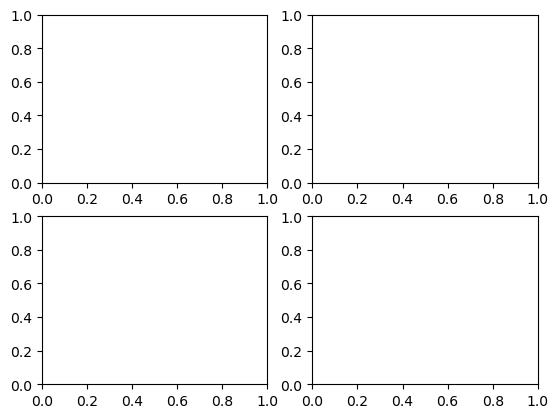

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X[1], cmap = 'gray')
axarr[0,1].imshow(y[1,:,:], cmap = 'gray')
axarr[1,0].imshow(X_val[1], cmap = 'gray')
axarr[1,1].imshow(y_val[1,:,:], cmap = 'gray')

plt.show()

In [ ]:
#Variables
filters = 16

#2 Criando a arquitetura

In [ ]:
#Definindo dice coeficiente
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype='float32')  # Convert y_true to float32
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

In [ ]:
input = Input((512, 512,1))

conv1 = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(input)
# Including batch normalization as possible fix to all black prediction
#conv1 = BatchNormalization()(conv1)
conv1_ = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv1)
#conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)

pool1.shape

TensorShape([None, 256, 256, 64])

In [ ]:
conv2 = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool1)
#conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv2)
#conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)

pool2.shape

TensorShape([None, 128, 128, 128])

In [ ]:
conv3 = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool2)
#conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv3)
#conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size = (2,2))(conv3)

pool3.shape

TensorShape([None, 64, 64, 256])

In [ ]:
conv4 = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool3)
#conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv4)
#conv4 = BatchNormalization()(conv4)
#drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size = (2,2))(conv4)

pool4.shape

TensorShape([None, 32, 32, 512])

In [ ]:
conv5 = Conv2D(filters*32, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(filters*32, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv5)
conv5 = BatchNormalization()(conv5)
#drop5 = Dropout(0.5)(conv5)

conv5.shape

TensorShape([None, 32, 32, 1024])

In [ ]:
convUp = Conv2DTranspose(filters*16, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv5)
convUp = Concatenate()([convUp, conv4])
convUp = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 64, 64, 512])

In [ ]:
convUp = Conv2DTranspose(filters*8, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Concatenate()([convUp, conv3])
convUp = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 128, 128, 256])

In [ ]:
convUp = Conv2DTranspose(filters*4, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Concatenate()([convUp, conv2])
convUp = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 256, 256, 128])

In [ ]:
convUp = Conv2DTranspose(filters*2, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Concatenate()([convUp, conv1])
convUp = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 512, 512, 64])

In [ ]:
output = Conv2D(1, (1,1), activation = 'sigmoid', kernel_initializer = 'he_uniform')(convUp)
output.shape

model = Model(inputs = [input], outputs = [output])
#Now using MeanIoU instead of accuracy
'''
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         MeanIoU(num_classes=2, name = 'MeanIoU', ignore_class=0)])
'''
#Using only dice
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss = [dice_loss], #loss = [dice_loss]
              metrics = [dice_coefficient])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 512, 512, 64  640         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_28 (MaxPooling2D  (None, 256, 256, 64  0          ['conv2d_133[0][0]']             
 )                              )                                                           

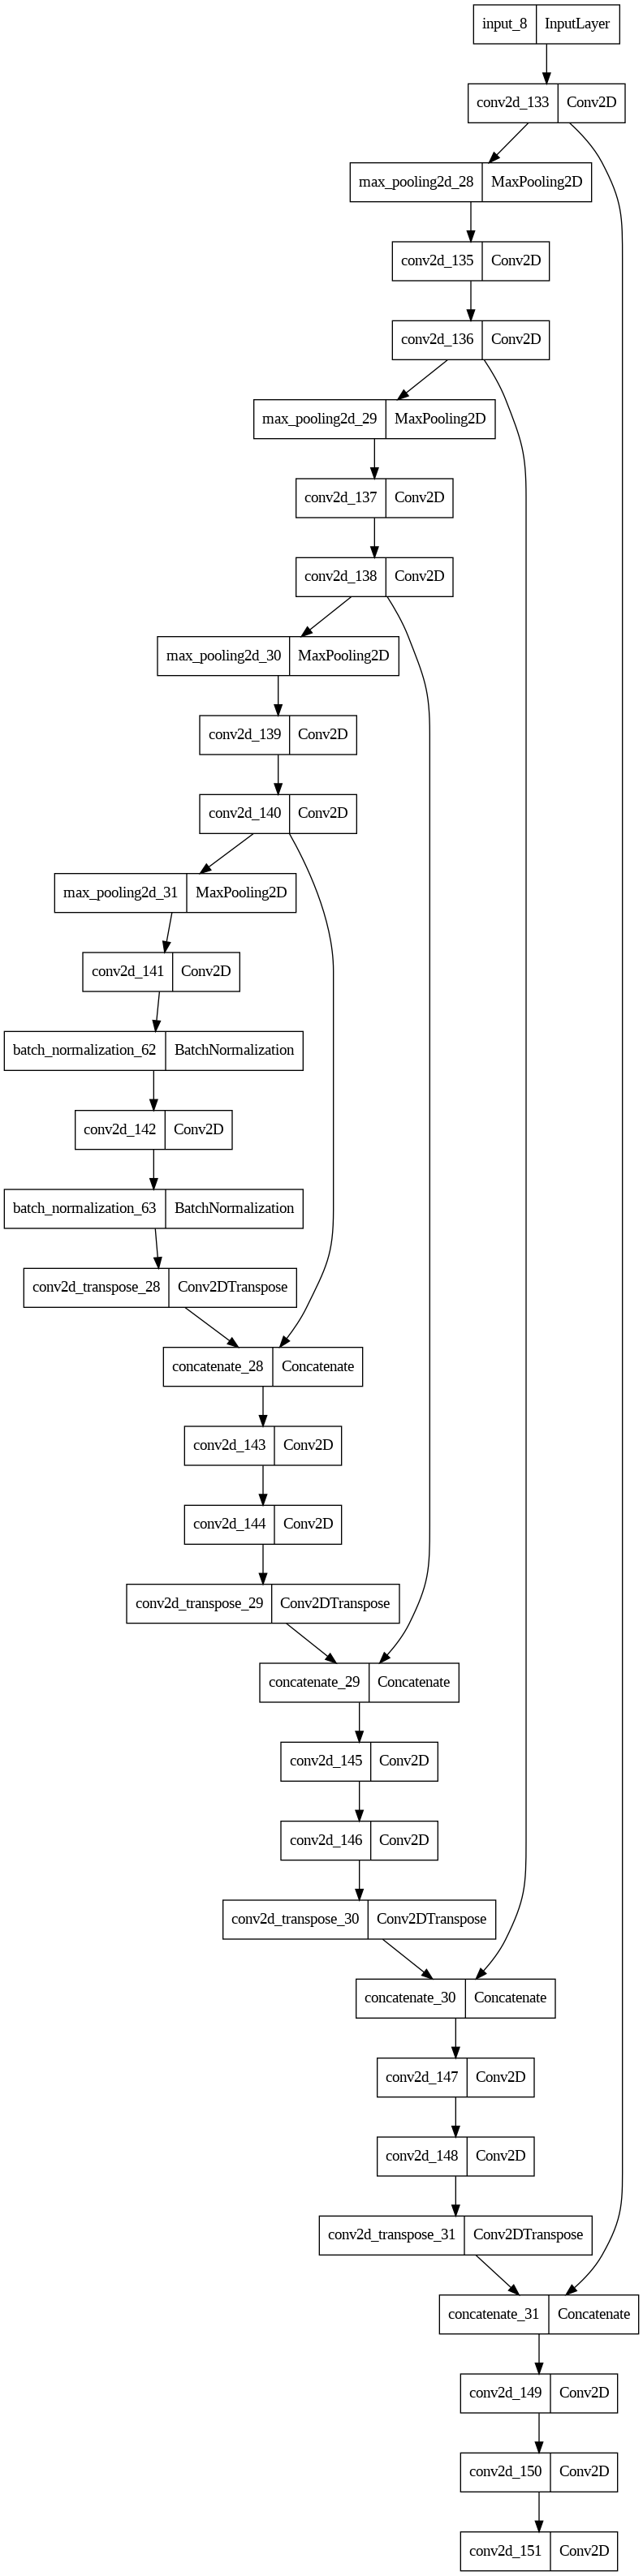

In [ ]:
tf.keras.utils.plot_model(model, "model.png")

#3 Treinando a rede

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.h5', save_freq = 'epoch')
#model.load_weights("model.h5")
history = model.fit(X, y, epochs=50, batch_size = 8, callbacks = [checkpoint], validation_data=(X_val, y_val))

Epoch 1/50
53/53 [==============================] - 100s 2s/step - loss: 0.7003 - dice_coefficient: 0.2997 - val_loss: 0.6986 - val_dice_coefficient: 0.3014
Epoch 2/50
53/53 [==============================] - 92s 2s/step - loss: 0.6983 - dice_coefficient: 0.3017 - val_loss: 0.6986 - val_dice_coefficient: 0.3014
Epoch 3/50
53/53 [==============================] - 92s 2s/step - loss: 0.6983 - dice_coefficient: 0.3017 - val_loss: 0.6986 - val_dice_coefficient: 0.3014
Epoch 4/50
53/53 [==============================] - 93s 2s/step - loss: 0.6983 - dice_coefficient: 0.3017 - val_loss: 0.6986 - val_dice_coefficient: 0.3014
Epoch 5/50
53/53 [==============================] - 93s 2s/step - loss: 0.6983 - dice_coefficient: 0.3017 - val_loss: 0.6986 - val_dice_coefficient: 0.3014
Epoch 6/50
53/53 [==============================] - 93s 2s/step - loss: 0.6983 - dice_coefficient: 0.3017 - val_loss: 0.6986 - val_dice_coefficient: 0.3014
Epoch 7/50
53/53 [==============================] - 97s 2s/step

KeyboardInterrupt: ignored

#4 Testes

In [ ]:
#model = tf.keras.models.load_model('model.31.h5')
a = X_val[0:10]
test = model.predict(a)
#X_val.shape

1/1 [==============================] - 0s 355ms/step


In [ ]:
image_id = 7

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X_val[image_id], cmap = 'gray')
axarr[0,1].imshow(y_val[image_id,:,:], cmap = 'gray')
axarr[1,0].imshow(X_val[image_id], cmap = 'gray')
axarr[1,1].imshow(test[image_id,:,:], cmap = 'gray')

plt.show()

In [ ]:
import pickle


with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)